## CSS Project Part 2
Arathy Pillai, Alexander Guth, Hammad Akthar, Hiba Saleel and Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.plotting import scatter_matrix
from string import punctuation
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm

In [2]:
plot_size = plt.rcParams["figure.figsize"]  
plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

### Load data and determine na values
repost and Text are determined as na values, because they ... **[TODO]**

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0', '', 'Text', 'repost', 'r e p o s t -', 'Repost']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)
#ira_data = ira_data[(ira_data['AD_IMPRESSIONS']> 0) & ira_data['AD_CLICKS'] > 0]

### Click per View Ratio
#Clicks / #Impressions

In [4]:
ira_data.insert(5, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

### Date operations
Get epoch time (ms since 01.01.1970)

In [5]:
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

def time_to_ms(dt):
    return dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1000 / 1000

In [6]:
ira_data['AD_CREATION_WEEKDAY'] = ira_data['AD_CREATION_DATE'].dt.dayofweek
ira_data['AD_CREATION_YEAR'] = ira_data['AD_CREATION_DATE'].dt.year
ira_data['AD_CREATION_MONTH'] = ira_data['AD_CREATION_DATE'].dt.month
ira_data['AD_CREATION_DAY'] = ira_data['AD_CREATION_DATE'].dt.day
ira_data['AD_CREATION_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: time_to_ms(x))
ira_data['AD_CREATION_EPOCH_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: unix_time_millis(x))

### Convert ruble
Removes "RUB" from the cell AD_SPEND

In [7]:
ira_data['AD_SPEND']=ira_data['AD_SPEND'].str.replace(' RUB','').astype('float')

### Drop all subsets, where AD_TEXT is na

In [8]:
ira_data=ira_data.dropna(subset=['AD_TEXT']);
ira_data['AD_TEXT'].count()

3436

### Cleaning up Targeting Data

In [9]:
def remove_punctuation_at_the_end(x):
    #remove "," and "." and ":" from the end of x
    x = x.rstrip(',')
    x = x.rstrip('.')
    x = x.rstrip(':')
    #replace ";" and ",." with "," in x
    x = x.replace(';', ',')
    x = x.replace(',.', ',')
    return x

In [10]:
#replace abbreviations with their long form in AD_TARGETING_EXCLUDED_CONNECTIONS
ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS']=ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS'].str.replace('Exclude people who like BM','Exclude people who like Black Matters')

#replace ")or" (missing space) with ") or" and ");" with ")," in AD_TARGETING_LANGUAGE due to having a different formats used
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\)or', ') or')
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\);', '),')

#??Remove lines without AD_TARGETING_INTERESTS and execute remove_punctuation_at_the_end on each string in AD_TARGETING_INTERESTS
ira_data['AD_TARGETING_INTERESTS'] = ira_data['AD_TARGETING_INTERESTS'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'] = ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_EXCLUDE'] = ira_data['AD_TARGETING_EXCLUDE'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))

### Remove hyperlinks

In [11]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

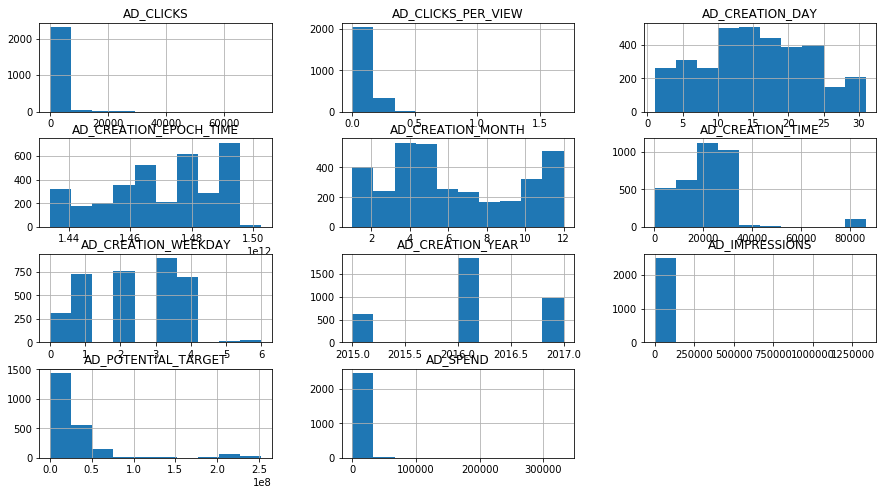

In [12]:
ira_data.hist();

### Flag all duplicate ad texts

In [13]:
ira_data['Duplicate'] = ira_data['AD_TEXT'].duplicated(keep=False)

### Total Duplicates

In [14]:
ira_data['AD_TEXT'].count()

3436

In [15]:
ira_data['Duplicate'].value_counts()

False    1998
True     1438
Name: Duplicate, dtype: int64

### Unique Duplicate Pairs

In [16]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].nunique()

361

### Occurence of Duplicate Pairs

In [17]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].value_counts().values

array([53, 23, 18, 16, 14, 14, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10,
       10, 10,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2

In [18]:
ira_data[(ira_data['Duplicate'] == True) & ira_data['AD_TEXT'].str.match('We speak for all fellow members of LGBT community across the nation.')][['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_DATE', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME','AD_TEXT', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].head(20)

,AD_CLICKS,AD_IMPRESSIONS,AD_CREATION_DATE,AD_CREATION_WEEKDAY,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME,AD_TEXT,AD_SPEND,AD_POTENTIAL_TARGET
AD_ID,,,,,,,,,,,
580,103.0,122.0,2015-06-16 03:36:10,1,2015,6,16,12970.0,We speak for all fellow members of LGBT commun...,129.66,35000000.0
581,36.0,1438.0,2015-06-17 03:15:18,2,2015,6,17,11718.0,We speak for all fellow members of LGBT commun...,1362.57,144000000.0
582,1724.0,18891.0,2015-06-18 00:58:48,3,2015,6,18,3528.0,We speak for all fellow members of LGBT commun...,10085.77,35000000.0
583,186.0,4265.0,2015-06-22 08:19:07,0,2015,6,22,29947.0,We speak for all fellow members of LGBT commun...,1393.55,139000000.0
584,3206.0,31618.0,2015-06-23 05:06:57,1,2015,6,23,18417.0,We speak for all fellow members of LGBT commun...,16630.20,143000000.0
585,1252.0,11857.0,2015-07-01 02:55:07,2,2015,7,1,10507.0,We speak for all fellow members of LGBT commun...,5538.24,165000000.0
586,59.0,1811.0,2015-07-07 01:51:07,1,2015,7,7,6667.0,We speak for all fellow members of LGBT commun...,757.65,166000000.0
587,542.0,15175.0,2015-07-09 01:50:28,3,2015,7,9,6628.0,We speak for all fellow members of LGBT commun...,6201.70,35000000.0
588,21449.0,175460.0,2015-07-14 00:01:38,1,2015,7,14,98.0,We speak for all fellow members of LGBT commun...,93754.38,41000000.0


### Dealing with Missing Values

Multiple Imputation using MICE (Multiple Imputation by Chained Equations)

In [19]:
# https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e
#from fancyimpute import MICE
#ira_cols=list(ira_data)
#ira_data = pd.DataFrame(MICE(verbose=False).complete(ira_data))
#ira_data.columns = ira_cols

### Common Statistics
**[TODO]** Mean, median etc. for success --> Chart(?) ==> Alex

### Correlations
**TODO** Handling of Outliers?, beautify the plot (axis labels, etc.), correlation of time

In [20]:
colormap = plt.cm.RdBu

In [21]:
corrDf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].dropna()

In [22]:
std_dev = 3
corrDf = corrDf[(np.abs(stats.zscore(corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY']])) < float(std_dev)).all(axis=1)]

In [23]:
corrDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1561 entries, 1 to 3517
Data columns (total 11 columns):
AD_CLICKS                 1561 non-null float64
AD_IMPRESSIONS            1561 non-null float64
AD_CLICKS_PER_VIEW        1561 non-null float64
AD_SPEND                  1561 non-null float64
AD_POTENTIAL_TARGET       1561 non-null float64
AD_CREATION_WEEKDAY       1561 non-null int64
AD_CREATION_EPOCH_TIME    1561 non-null float64
AD_CREATION_YEAR          1561 non-null int64
AD_CREATION_MONTH         1561 non-null int64
AD_CREATION_DAY           1561 non-null int64
AD_CREATION_TIME          1561 non-null float64
dtypes: float64(7), int64(4)
memory usage: 146.3 KB


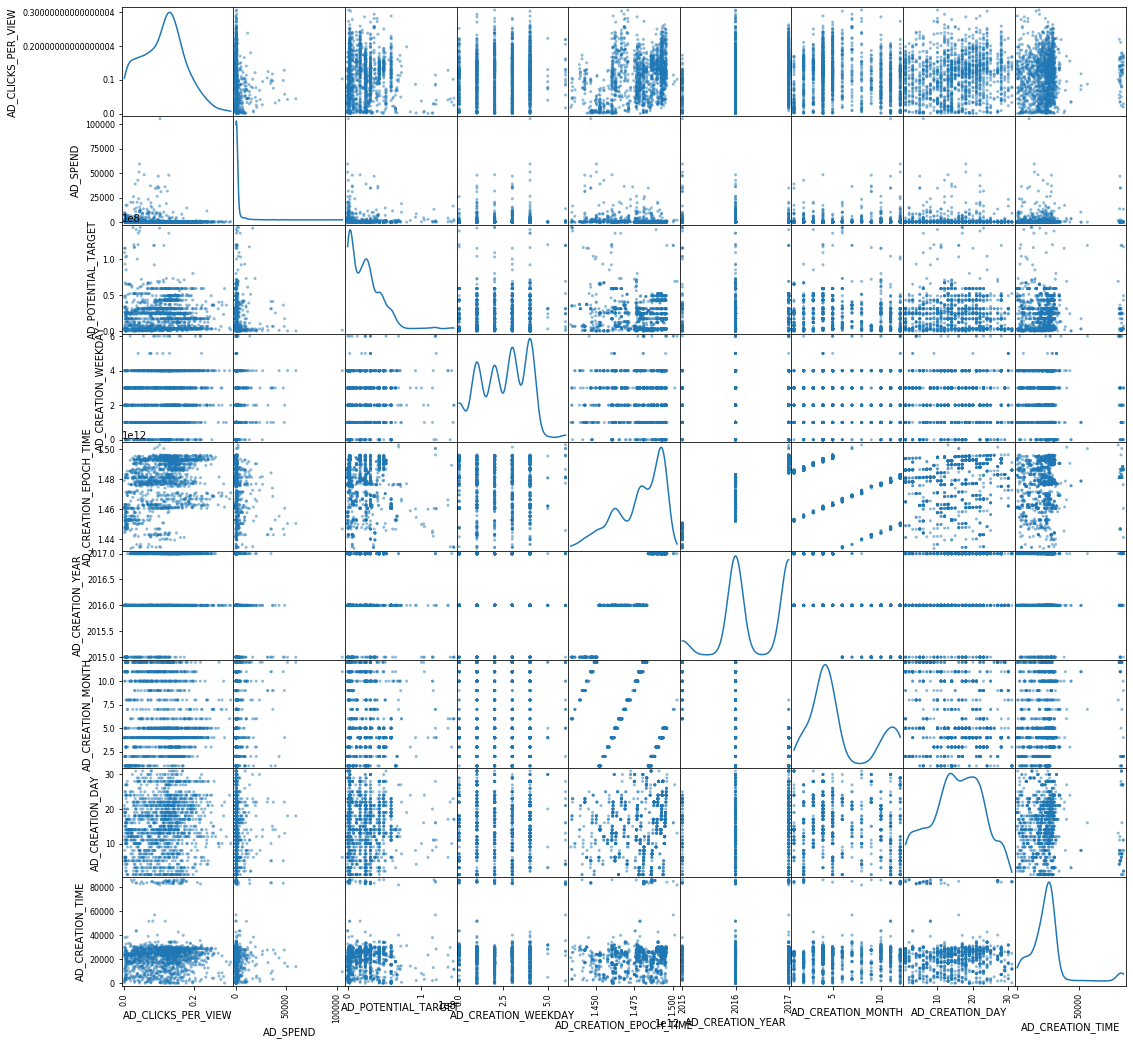

In [24]:
scatter_matrix(corrDf[['AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterALL.png")

In [25]:
corr = corrDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()
corr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME
AD_CLICKS,1.000000,0.774459,0.276032,0.312826,0.082201,0.234158,0.215610,-0.062069,-0.003416,0.095631
AD_IMPRESSIONS,0.774459,1.000000,-0.065630,0.543079,0.041728,0.057677,0.052223,-0.011018,-0.035323,0.032362
AD_CLICKS_PER_VIEW,0.276032,-0.065630,1.000000,-0.152962,-0.010226,0.355368,0.323261,-0.096563,0.154860,0.080396
AD_SPEND,0.312826,0.543079,-0.152962,1.000000,-0.067132,-0.210235,-0.211786,0.097488,-0.043595,-0.010906
AD_POTENTIAL_TARGET,0.082201,0.041728,-0.010226,-0.067132,1.000000,-0.154291,-0.083515,-0.081568,-0.016343,-0.038136
AD_CREATION_EPOCH_TIME,0.234158,0.057677,0.355368,-0.210235,-0.154291,1.000000,0.890258,-0.214027,0.193047,0.132188
AD_CREATION_YEAR,0.215610,0.052223,0.323261,-0.211786,-0.083515,0.890258,1.000000,-0.634262,0.202631,0.048024
AD_CREATION_MONTH,-0.062069,-0.011018,-0.096563,0.097488,-0.081568,-0.214027,-0.634262,1.000000,-0.176425,0.122433
AD_CREATION_DAY,-0.003416,-0.035323,0.154860,-0.043595,-0.016343,0.193047,0.202631,-0.176425,1.000000,-0.033065
AD_CREATION_TIME,0.095631,0.032362,0.080396,-0.010906,-0.038136,0.132188,0.048024,0.122433,-0.033065,1.000000


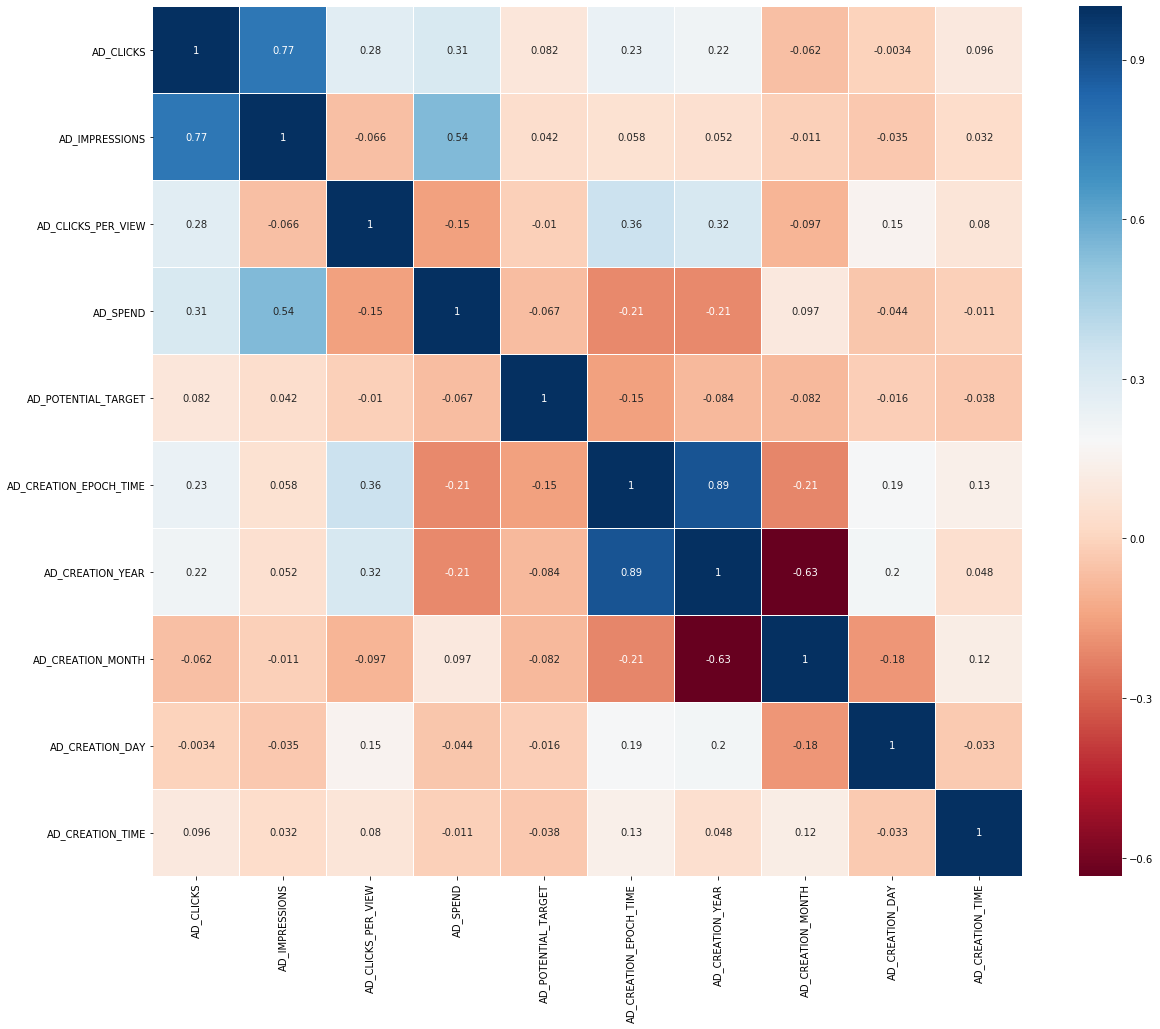

In [26]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(corr,ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrALL.png")

In [27]:
corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.890972,0.491061,0.067645
AD_IMPRESSIONS,0.890972,1.000000,0.143829,0.046365
AD_CLICKS_PER_VIEW,0.491061,0.143829,1.000000,0.072965
AD_CREATION_WEEKDAY,0.067645,0.046365,0.072965,1.000000


#### Correlation: Unique Dataset

In [28]:
corrUniqueDf = ira_data[ira_data['Duplicate']==False][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].dropna()

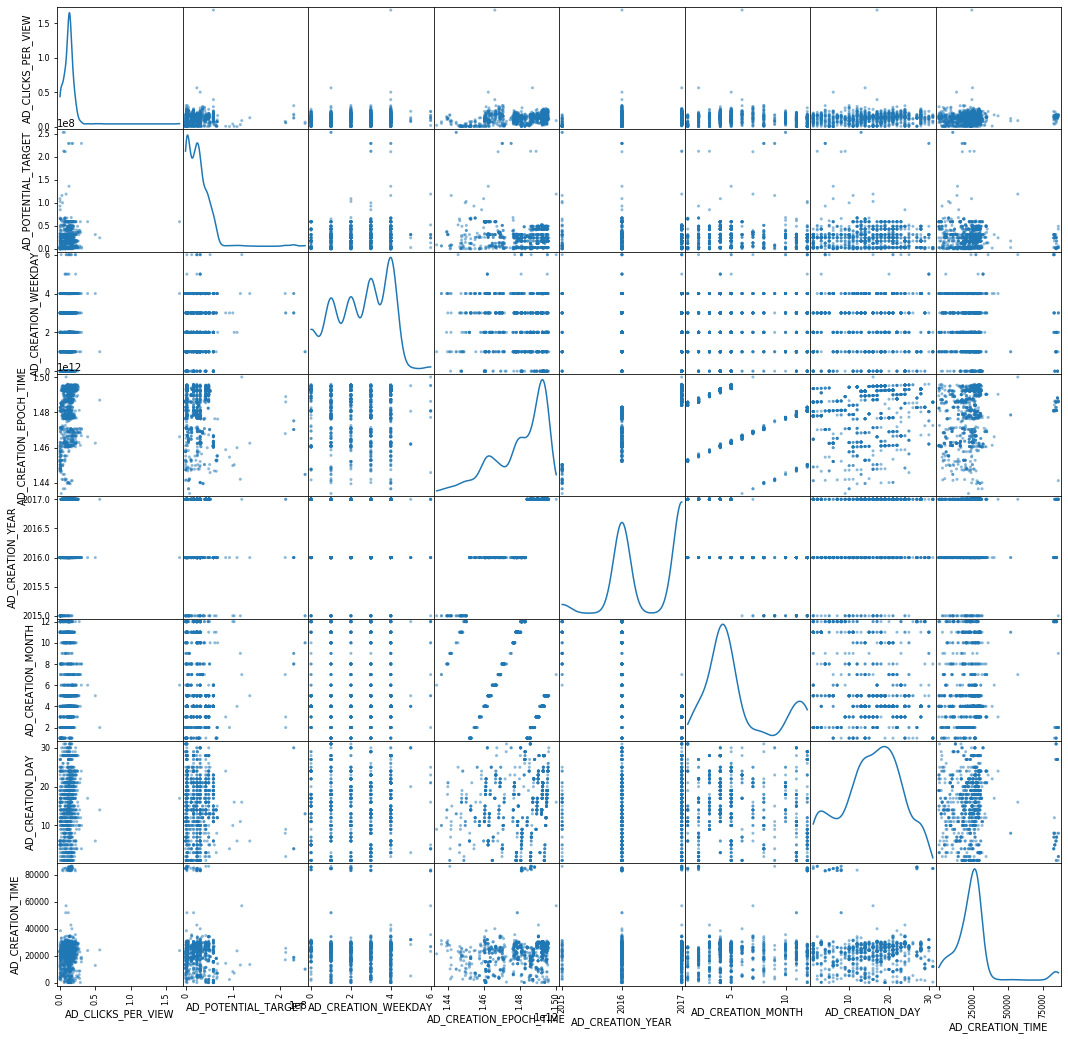

In [29]:
scatter_matrix(corrUniqueDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterUnique.png")

In [30]:
uCorr = corrUniqueDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()
uCorr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME
AD_CLICKS,1.000000,0.883314,0.075732,0.516598,0.082800,0.178839,0.166382,-0.060130,-0.010136,0.048912
AD_IMPRESSIONS,0.883314,1.000000,-0.073856,0.720094,0.068237,0.041758,0.041729,-0.018529,-0.026064,0.007835
AD_CLICKS_PER_VIEW,0.075732,-0.073856,1.000000,-0.126283,0.018458,0.224331,0.215502,-0.098365,0.111743,0.075590
AD_SPEND,0.516598,0.720094,-0.126283,1.000000,0.074783,-0.089475,-0.086542,0.038309,-0.018856,-0.037302
AD_POTENTIAL_TARGET,0.082800,0.068237,0.018458,0.074783,1.000000,-0.215345,-0.148597,-0.031076,-0.055112,-0.115874
AD_CREATION_EPOCH_TIME,0.178839,0.041758,0.224331,-0.089475,-0.215345,1.000000,0.890989,-0.272623,0.234018,0.177527
AD_CREATION_YEAR,0.166382,0.041729,0.215502,-0.086542,-0.148597,0.890989,1.000000,-0.678409,0.245738,0.080680
AD_CREATION_MONTH,-0.060130,-0.018529,-0.098365,0.038309,-0.031076,-0.272623,-0.678409,1.000000,-0.214575,0.117084
AD_CREATION_DAY,-0.010136,-0.026064,0.111743,-0.018856,-0.055112,0.234018,0.245738,-0.214575,1.000000,-0.024647
AD_CREATION_TIME,0.048912,0.007835,0.075590,-0.037302,-0.115874,0.177527,0.080680,0.117084,-0.024647,1.000000


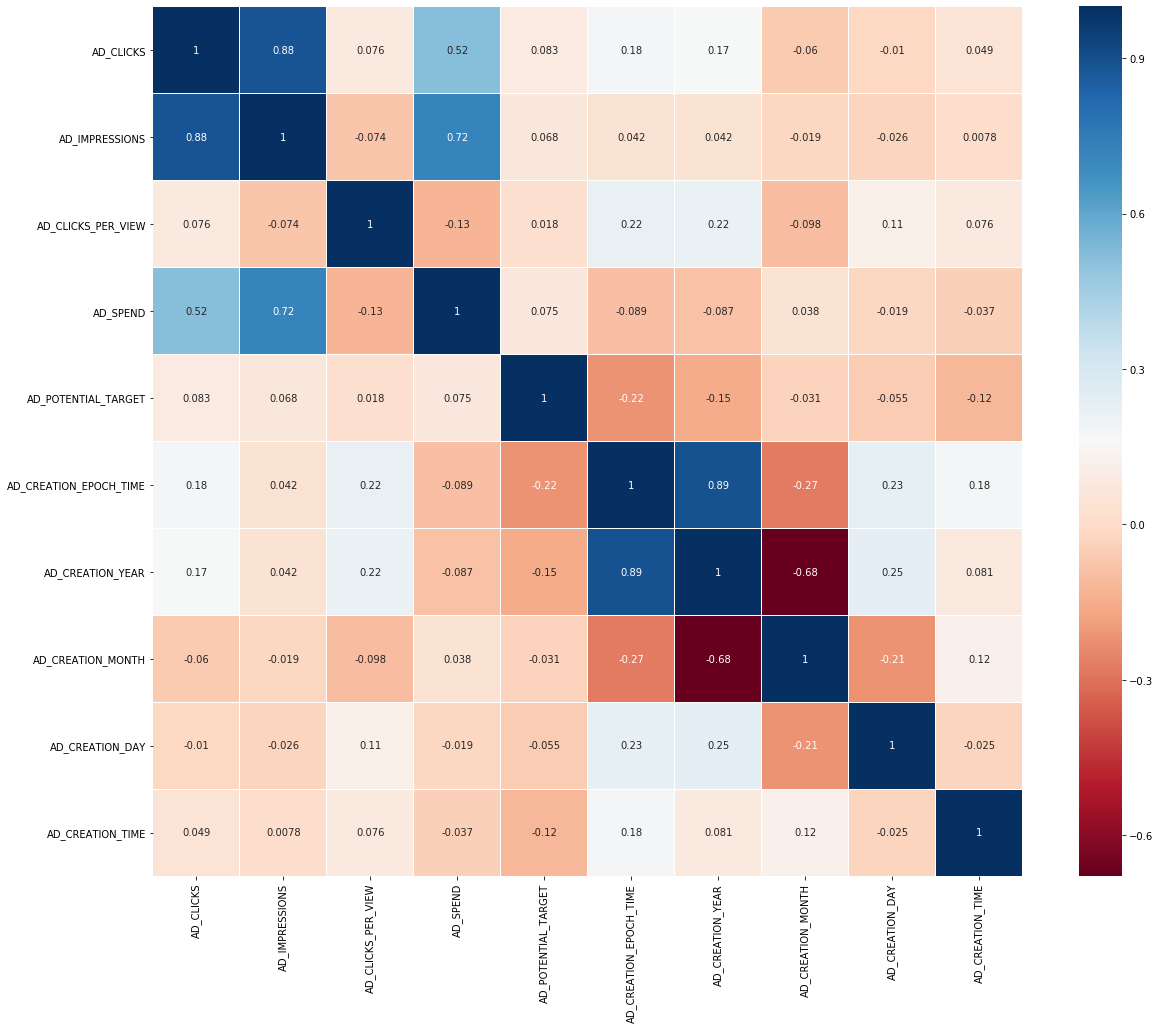

In [31]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(uCorr, ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrUnique.png")

In [32]:
corrUniqueDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.886410,0.421503,0.042784
AD_IMPRESSIONS,0.886410,1.000000,0.072149,0.012415
AD_CLICKS_PER_VIEW,0.421503,0.072149,1.000000,0.075176
AD_CREATION_WEEKDAY,0.042784,0.012415,0.075176,1.000000


#### Correlation: Duplicate Dataset

In [33]:
corrDuplicateDf = ira_data[ira_data['Duplicate']==True][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].dropna()

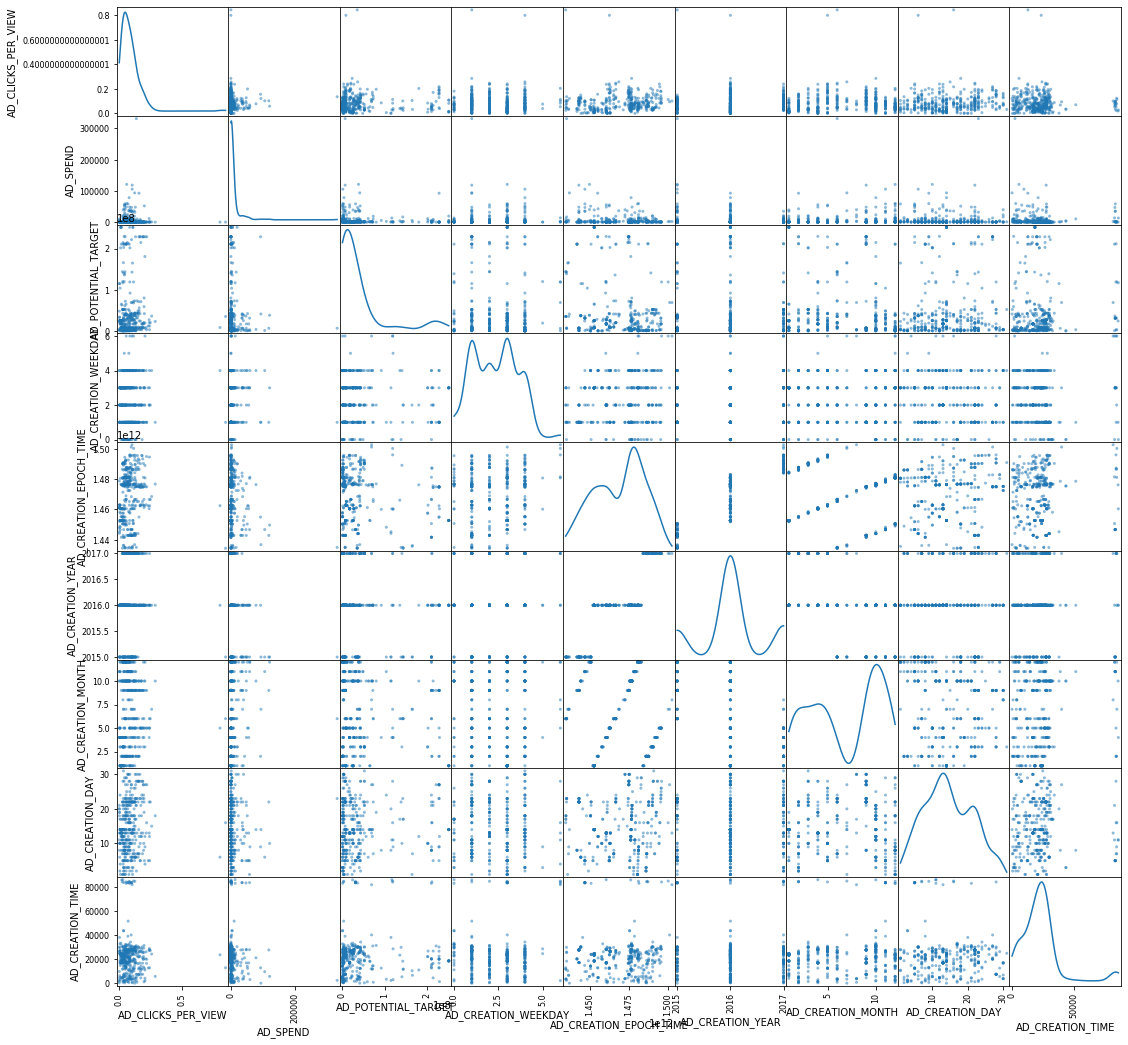

In [34]:
scatter_matrix(corrDuplicateDf[['AD_CLICKS_PER_VIEW', 'AD_SPEND','AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterDuplicate.png")

In [35]:
dCorr = corrDuplicateDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()
dCorr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME
AD_CLICKS,1.000000,0.911264,0.057086,0.834786,-0.083124,-0.025844,-0.073591,0.100410,-0.027273,-0.013914
AD_IMPRESSIONS,0.911264,1.000000,-0.041435,0.666336,-0.097229,0.004122,-0.061432,0.129470,-0.069541,-0.013166
AD_CLICKS_PER_VIEW,0.057086,-0.041435,1.000000,0.016955,0.013216,0.098913,0.046082,0.069331,0.112961,-0.040721
AD_SPEND,0.834786,0.666336,0.016955,1.000000,-0.051941,-0.183734,-0.200342,0.080554,-0.013793,-0.060351
AD_POTENTIAL_TARGET,-0.083124,-0.097229,0.013216,-0.051941,1.000000,-0.137627,-0.074803,-0.087708,0.040245,0.040933
AD_CREATION_EPOCH_TIME,-0.025844,0.004122,0.098913,-0.183734,-0.137627,1.000000,0.853441,0.017525,0.084654,0.025039
AD_CREATION_YEAR,-0.073591,-0.061432,0.046082,-0.200342,-0.074803,0.853441,1.000000,-0.505120,0.043072,-0.037516
AD_CREATION_MONTH,0.100410,0.129470,0.069331,0.080554,-0.087708,0.017525,-0.505120,1.000000,-0.005057,0.115991
AD_CREATION_DAY,-0.027273,-0.069541,0.112961,-0.013793,0.040245,0.084654,0.043072,-0.005057,1.000000,-0.054553
AD_CREATION_TIME,-0.013914,-0.013166,-0.040721,-0.060351,0.040933,0.025039,-0.037516,0.115991,-0.054553,1.000000


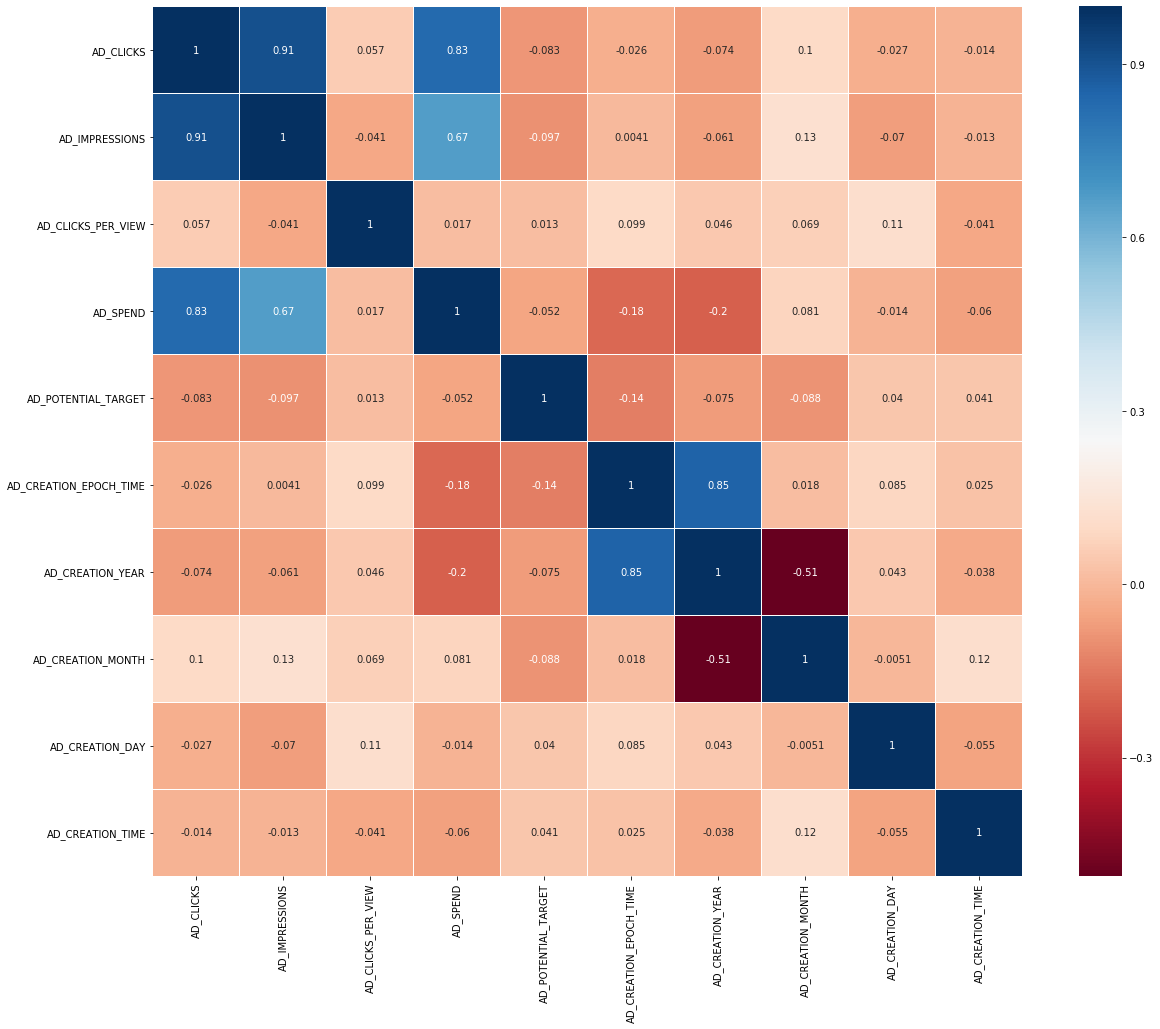

In [36]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(dCorr,ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrDuplicate.png")

In [37]:
corrDuplicateDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.924228,0.505427,0.105235
AD_IMPRESSIONS,0.924228,1.000000,0.215173,0.134442
AD_CLICKS_PER_VIEW,0.505427,0.215173,1.000000,-0.041521
AD_CREATION_WEEKDAY,0.105235,0.134442,-0.041521,1.000000


### Regression Model (Elastic Net)
**[TODO]** ==> Julian

In [38]:
X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']]
#X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_POTENTIAL_TARGET']]
Y= corrDf['AD_CLICKS_PER_VIEW']

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

#### Normal Multiple Linear Regression

In [40]:
reg = LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
y_pred = reg.predict(X_test)

In [42]:
print(reg.coef_)

[ 3.17373894e-03 -8.53413623e-11  2.73197030e+00  2.27454629e-01
  8.11178619e-03  3.79241689e-07  7.76453919e-11 -8.45985297e-07]


In [43]:
print(reg.intercept_)

-5383.9514724665505


**Very low R^2 score, so the prediction isn't very good**

In [44]:
r2_score(Y_test, y_pred)

0.11947884343032755

#### Multiple Linear Regression (Lasso)

In [45]:
regLasso = Lasso()
regLasso.fit(X_train, Y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [46]:
y_pred = regLasso.predict(X_test)

In [47]:
print(regLasso.coef_)

[ 0.00000000e+00  1.37834572e-12  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  2.03091095e-07  1.40250959e-10 -7.86658578e-07]


In [48]:
print(regLasso.intercept_)

-1.932767843547793


In [ ]:
r2_score(Y_test, y_pred)

#### Multiple Linear Regression (Ridge)

#### Multiple Linear Regression (Elastic Net)

------

In [49]:
regression=LinearRegression()
regression.fit(X,Y)
first_model=(mean_squared_error(y_true=Y,y_pred=regression.predict(X)))
print(first_model)

0.003241215365459957


In [50]:
coef_dict_baseline = {}
for coef, feat in zip(regression.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'AD_CREATION_WEEKDAY': 0.002733988448957941,
 'AD_CREATION_EPOCH_TIME': -7.406237116217646e-11,
 'AD_CREATION_YEAR': 2.3769271086174806,
 'AD_CREATION_MONTH': 0.19808209336458943,
 'AD_CREATION_DAY': 0.007075569350672144,
 'AD_CREATION_TIME': 2.800669555395734e-07,
 'AD_POTENTIAL_TARGET': 5.377694815304192e-11,
 'AD_SPEND': -9.070766546009423e-07}

### ElasticNet Regression

In [51]:
train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size=0.25, random_state=1)

In [52]:
reg_1 = LinearRegression()
reg_1.fit(train_x, train_y)
reg_1.coef_

array([ 2.73287267e-03, -7.53262626e-11,  2.41402245e+00,  2.01269779e-01,
        7.26044239e-03,  3.15498606e-07,  3.86031812e-11, -9.14179004e-07])

In [53]:
reg_1.intercept_

-4757.474822650694

In [54]:
lm = LinearRegression()
lm_lasso = Lasso()
lm_ridge=Ridge()
lm_elastic=ElasticNet()

In [55]:
reg_1.predict(test_x)

array([0.13190785, 0.10398619, 0.10615059, 0.104332  , 0.11768321,
       0.13299547, 0.1313761 , 0.14667575, 0.12514659, 0.09701113,
       0.09709991, 0.08176659, 0.14233048, 0.07540171, 0.08370369,
       0.10643853, 0.11892706, 0.13088677, 0.10633554, 0.11907024,
       0.13478356, 0.13802041, 0.13063823, 0.14656239, 0.0744046 ,
       0.1166687 , 0.08938157, 0.12162739, 0.10477755, 0.11844543,
       0.13245039, 0.08216711, 0.1032366 , 0.11098594, 0.13412209,
       0.14261057, 0.11178679, 0.14777401, 0.09075372, 0.17177241,
       0.13528724, 0.09436847, 0.13778818, 0.13123841, 0.12703262,
       0.1307938 , 0.09106361, 0.08589071, 0.08962749, 0.13548703,
       0.14247355, 0.1425275 , 0.10877371, 0.10879451, 0.10321735,
       0.10466856, 0.08347396, 0.128429  , 0.12309406, 0.0968963 ,
       0.10903146, 0.14658219, 0.10091537, 0.09288187, 0.09531084,
       0.10055467, 0.12021961, 0.13280895, 0.12895403, 0.10095319,
       0.10450528, 0.08781187, 0.11170221, 0.11649123, 0.11052

In [56]:
lm.fit(train_x, train_y)
lm_lasso.fit(train_x, train_y)
lm_ridge.fit(train_x, train_y)
lm_elastic.fit(train_x, train_y)

/anaconda3/envs/css/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.39196e-24): result may not be accurate.
  overwrite_a=True).T


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

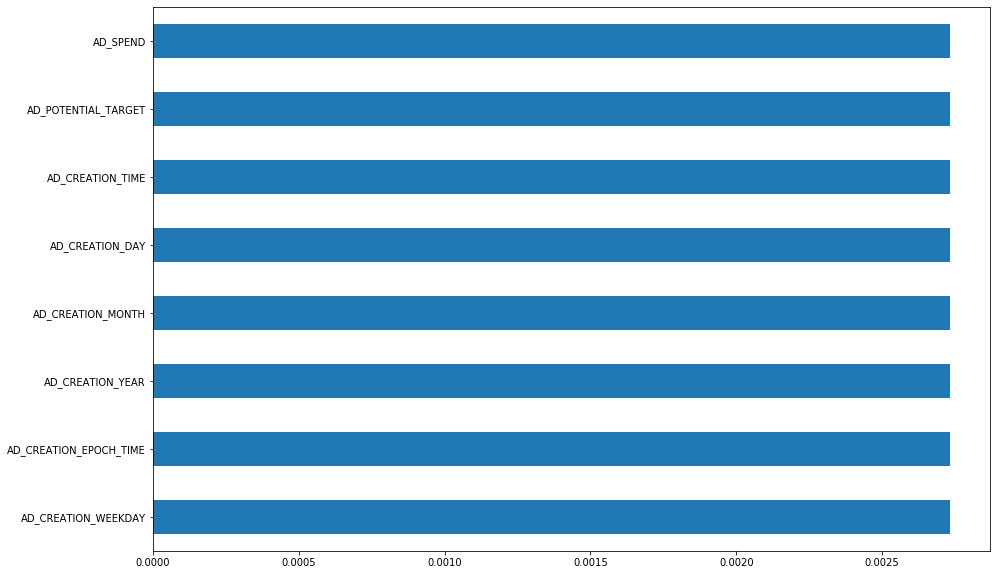

In [57]:
plt.figure(figsize=(15,10))
ft_importances_lm = pd.Series(lm.coef_[0], index = X.columns)
ft_importances_lm.plot(kind='barh')
plt.show();

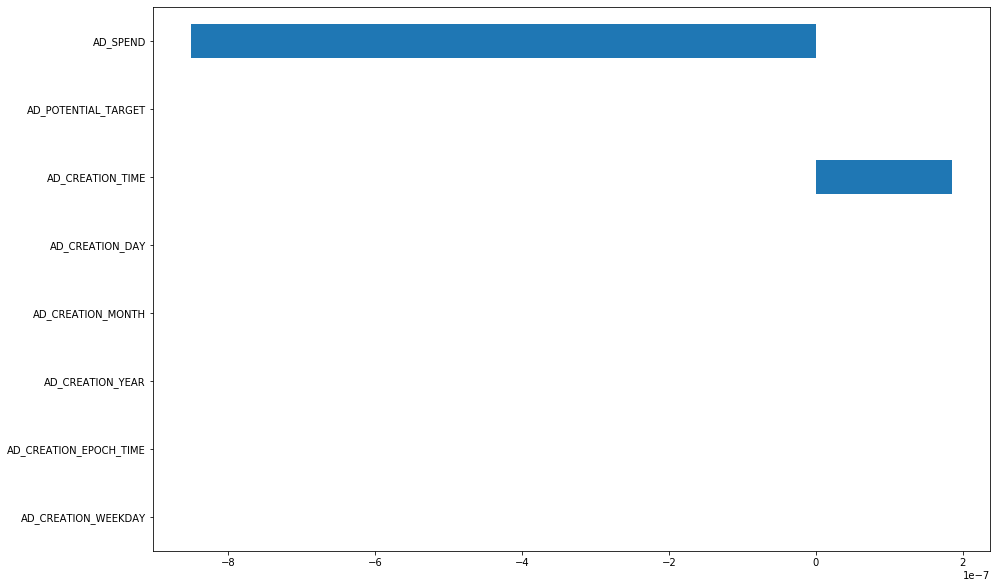

In [58]:
plt.figure(figsize=(15,10))
ft_importances_lm = pd.Series(lm_lasso.coef_, index = X.columns)
ft_importances_lm.plot(kind='barh')
plt.show();

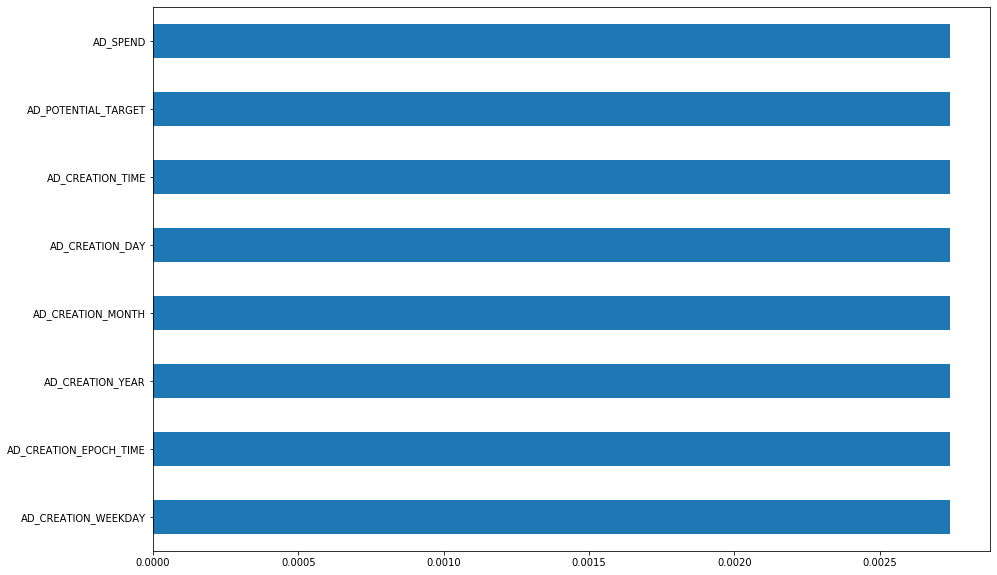

In [59]:
plt.figure(figsize=(15,10))
ft_importances_lm = pd.Series(lm_ridge.coef_[0], index = X.columns)
ft_importances_lm.plot(kind='barh')
plt.show();

In [60]:
lm_elastic.coef_

array([ 0.00000000e+00,  1.28759483e-12,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.87812507e-07,  9.39268233e-11, -8.66913295e-07])

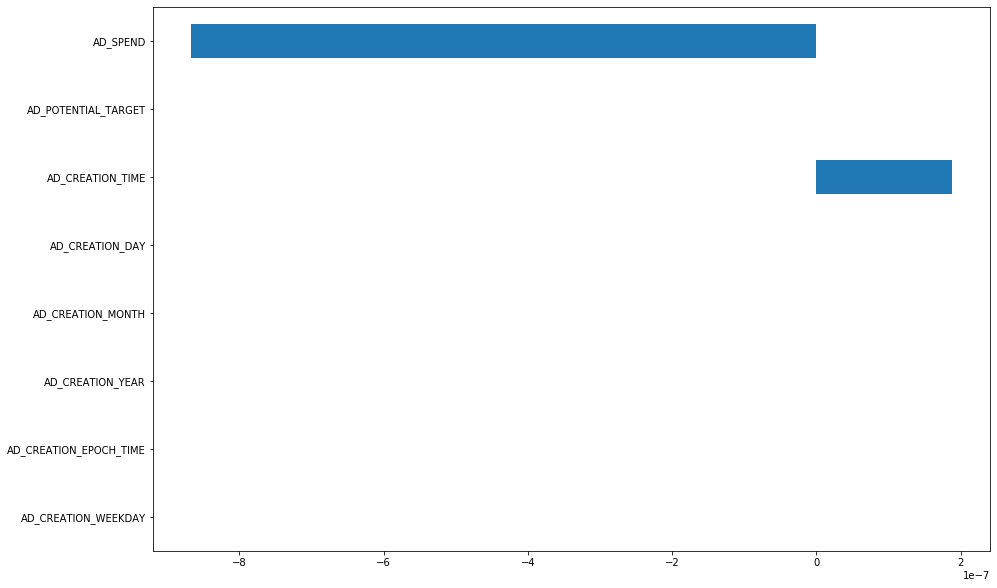

In [61]:
plt.figure(figsize=(15,10))
ft_importances_lm = pd.Series(lm_elastic.coef_, index = X.columns)
ft_importances_lm.plot(kind='barh')
plt.show();

In [62]:
print("RSquare Value for Simple Regression TEST data is-")
print(np.round(lm.score(test_x,test_y)*100,2))

print("RSquare Value for Lasso Regression TEST data is-")
print(np.round(lm_lasso.score(test_x,test_y)*100,2))

print("RSquare Value for Ridge Regression TEST data is-")
print(np.round(lm_ridge.score(test_x,test_y)*100,2))

print("RSquare Value for Elastic Regression TEST data is-")
print(np.round(lm_elastic.score(test_x,test_y)*100,2))

RSquare Value for Simple Regression TEST data is-
16.51
RSquare Value for Lasso Regression TEST data is-
15.59
RSquare Value for Ridge Regression TEST data is-
16.13
RSquare Value for Elastic Regression TEST data is-
15.58


In [63]:
predict_test_lm = lm.predict(test_x)
predict_test_lm_lasso = lm_lasso.predict(test_x)
predict_test_lm_ridge = lm_ridge.predict(test_x)
predict_test_lm_elastic = lm_elastic.predict(test_x)

In [64]:
print("Simple Regression Mean Square Error (MSE) for TEST data is")
print(np.round(mean_squared_error(test_y, predict_test_lm),2))

print("Lasso Regression Mean Square Error (MSE) for TEST data is")
print(np.round(mean_squared_error(test_y, predict_test_lm_lasso),2))

print("Ridge Regression Mean Square Error (MSE) for TEST data is")
print(np.round(mean_squared_error(test_y, predict_test_lm_ridge),2))

print("Elastic Regression Mean Square Error (MSE) for TEST data is")
print(np.round(mean_squared_error(test_y, predict_test_lm_elastic),2))

Simple Regression Mean Square Error (MSE) for TEST data is
0.0
Lasso Regression Mean Square Error (MSE) for TEST data is
0.0
Ridge Regression Mean Square Error (MSE) for TEST data is
0.0
Elastic Regression Mean Square Error (MSE) for TEST data is
0.0


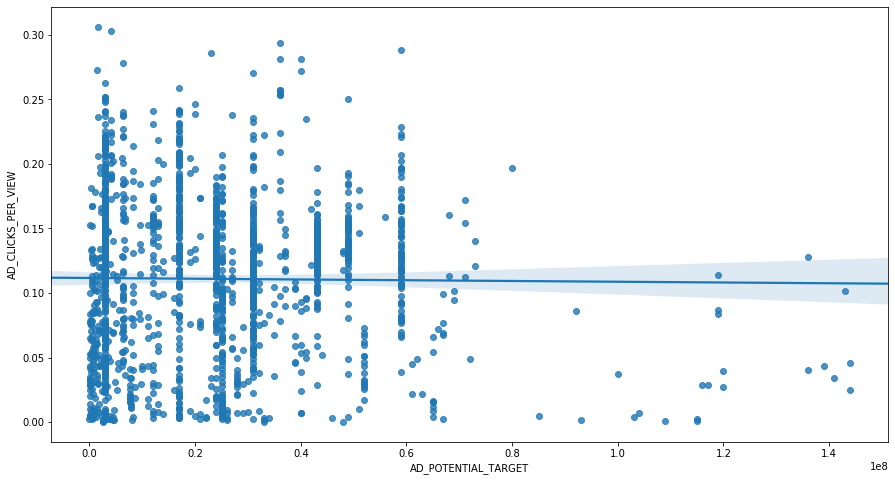

In [65]:
sns.regplot(x="AD_POTENTIAL_TARGET", y="AD_CLICKS_PER_VIEW", data=corrDf)

In [66]:
elastic=ElasticNet(normalize=True)
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

In [67]:
search.fit(X,Y)
search.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.4}

In [68]:
abs(search.best_score_)

0.0034562567087573067

In [69]:
elastic=ElasticNet(normalize=True,alpha=0.0001,l1_ratio=0.4)
elastic.fit(X,Y)
second_model=(mean_squared_error(y_true=Y,y_pred=elastic.predict(X)))
print(second_model)

0.003280935789242381


In [70]:
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'AD_CREATION_WEEKDAY': 0.0016450121745752758,
 'AD_CREATION_EPOCH_TIME': 8.892590684159243e-13,
 'AD_CREATION_YEAR': 0.00673780098909057,
 'AD_CREATION_MONTH': 0.0,
 'AD_CREATION_DAY': 0.000506455462085136,
 'AD_CREATION_TIME': 1.01018795853331e-07,
 'AD_POTENTIAL_TARGET': 0.0,
 'AD_SPEND': -6.66217862122613e-07}

### Polynomial Regression

In [71]:
def pol_regression(X, Y):
    transformer = PolynomialFeatures(degree=2, include_bias=True)
    transformer.fit(X)
    X_ = transformer.transform(X)
    model = LinearRegression()
    model.fit(X_, Y)
    intercept, coefficients = model.intercept_, model.coef_
    r_sq = model.score(X_, Y)
    y_pred = model.predict(X_)
    return dict([('intercept', intercept), ('coefficients', coefficients), ('r_sq', r_sq), ('pred', y_pred)])

In [72]:
print(pol_regression(X, Y))

{'intercept': -23.731155503779036, 'coefficients': array([-1.19099425e-12,  4.93225758e-13, -7.33822148e-14, -1.18714354e-19,
        8.72449387e-20,  1.27242595e-19,  4.69219472e-17,  4.56732103e-15,
        1.59565976e-17, -5.62140869e-19,  3.10550844e-15, -7.21487920e-17,
        1.53673498e-16, -2.69241312e-15, -4.81317530e-15, -7.13465006e-11,
        1.98067782e-15, -1.05003847e-23,  1.57195627e-14,  9.57775932e-16,
        7.39074489e-16,  4.17777137e-20, -9.83091000e-21, -2.73087002e-18,
       -1.31399841e-18,  9.66058908e-18,  1.58753123e-17,  9.27635180e-14,
        7.63943573e-12,  3.01644244e-14,  2.83587602e-19,  2.89856812e-18,
        2.13275762e-15,  1.66566165e-11,  3.17559027e-15, -3.72264473e-18,
       -2.91095001e-14, -9.09903227e-12, -6.77369455e-15,  2.28607572e-12,
       -3.18774278e-15,  2.16043108e-11, -7.42863953e-18,  2.09628086e-14,
        4.72586593e-11]), 'r_sq': 0.18470072127454695, 'pred': array([0.09071707, 0.06709642, 0.06015868, ..., 0.13830568, 0

### Regression with statsmodels

In [73]:
X_train = X[:-50]
X_test = X[-50:]

In [74]:
y_train = Y[:-50]
y_test = Y[-50:]

In [75]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
y_pred = model.predict(X_test)

In [77]:
# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [ 2.16620027e-03 -7.24950837e-11  2.32964277e+00  1.93732426e-01
  6.95159854e-03  2.78889462e-07  1.35930882e-10 -8.61489939e-07]
Mean squared error: 0.01
Variance score: -1.80


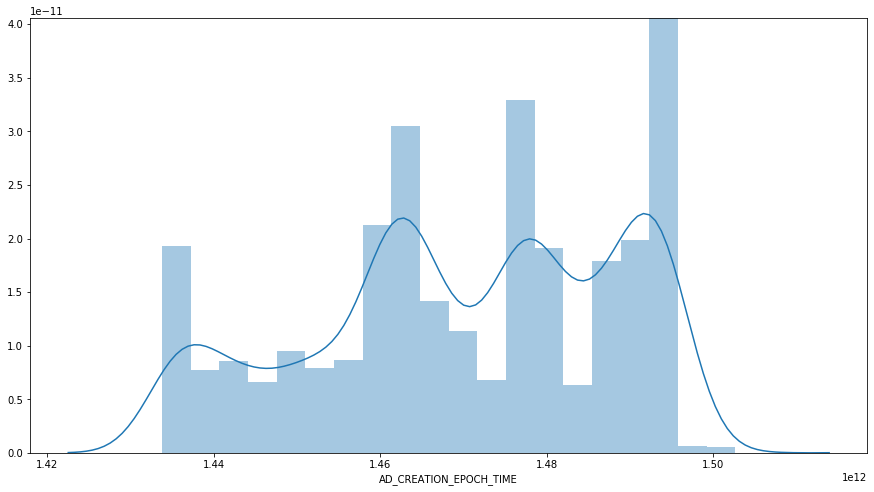

In [78]:
sns.distplot(ira_data['AD_CREATION_EPOCH_TIME'].dropna())

In [79]:
ira_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3436 entries, 1 to 3519
Data columns (total 31 columns):
AD_CLICKS                              2395 non-null float64
AD_CREATION_DATE                       3436 non-null datetime64[ns]
AD_END_DATE                            2293 non-null datetime64[ns]
AD_IMPRESSIONS                         2533 non-null float64
AD_LANDING_PAGE                        3411 non-null object
AD_CLICKS_PER_VIEW                     2395 non-null float64
AD_PATH                                3436 non-null object
AD_SPEND                               2484 non-null float64
AD_TARGETING_AGE                       3436 non-null object
AD_TARGETING_CUSTOM_AUDIENCE           31 non-null object
AD_TARGETING_EXCLUDE                   87 non-null object
AD_TARGETING_EXCLUDED_CONNECTIONS      943 non-null object
AD_TARGETING_EXCLUDE_LOCATION          42 non-null object
AD_TARGETING_FRIENDS_OF_CONNECTIONS    403 non-null object
AD_TARGETING_GENDER                    14

count    2395.000000
mean        0.107085
std         0.076755
min         0.000030
25%         0.054642
50%         0.105732
75%         0.146752
max         1.690789
Name: AD_CLICKS_PER_VIEW, dtype: float64


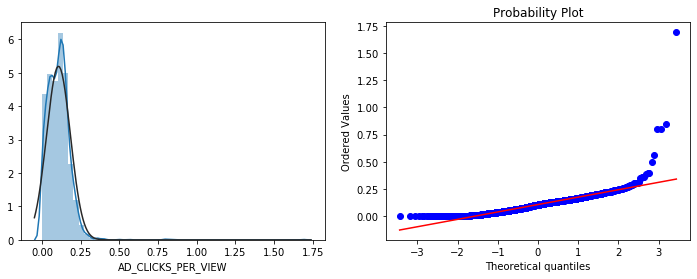

In [80]:
print(ira_data.AD_CLICKS_PER_VIEW.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(ira_data.AD_CLICKS_PER_VIEW.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(ira_data.AD_CLICKS_PER_VIEW.dropna(), plot=plt)

In [81]:
cpv = ira_data.AD_CLICKS_PER_VIEW
ira_data.AD_CLICKS_PER_VIEW = np.log(cpv)

count    2395.000000
mean       -2.575177
std         1.065514
min       -10.409793
25%        -2.906958
50%        -2.246849
75%        -1.919010
max         0.525196
Name: AD_CLICKS_PER_VIEW, dtype: float64


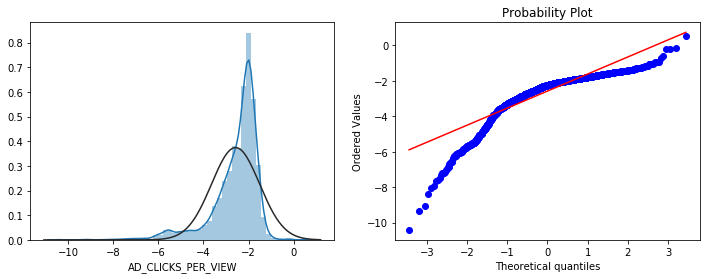

In [82]:
print(ira_data.AD_CLICKS_PER_VIEW.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(ira_data.AD_CLICKS_PER_VIEW.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(ira_data.AD_CLICKS_PER_VIEW.dropna(), plot=plt)